In [10]:
library(tidyverse)
library(reshape2)
library(patchwork)

In [11]:
setwd("/data/yangy34/projects/SARS2_host_derived_insertions/Figure1")

In [40]:
##########################################
######### Figure 1 left part #############
##########################################

plot_one_panel <- function(data, geneDfA, kimdata, fill_col, title_str){
    panel = ggplot() + 
    geom_col(data=data, aes(x=Position, y=scaled_count, fill=struct, color=struct)) + 
    geom_rect(data=geneDfA, xmin=0, xmax=29902, ymin=-0.1, ymax=0,
              color = "black",
              size = 0.2) +
    geom_rect(data = geneDfA, aes(xmin = V4, xmax = V5, ymin = -0.1, ymax = 0,
            fill = gene),
            color = "black",
            size = 0.2) +
    geom_text(data = geneDfA, aes(x=V4+(V5-V4)/2, y = c(0,0,0,0,0,-0.092,0,-0.092,0,0,-0.092)-0.0102, label = gene), 
        size = 5,
        angle = 0, vjust=1.5) +
    geom_segment(data=data, aes(x = 0, y = 0, xend = 29902, yend = 0), arrow = arrow(length = unit(0, "cm"))) +
    scale_fill_manual(values = c(fill_col, "#4b4b4b","#58bbd5","#6e25f2","#ca51f7",
                                "#c72d6e","#e86501","#4373e0","#979aff","#eecc00",
                                "#bccee3","#78c200")) + 
    scale_color_manual(values = c(fill_col)) +
    annotate(
        "text", label = "5\'",
        x = -500, y = 0, size = 7
    )+
    annotate(
        "text", label = "3\'",
        x = 30402, y = 0, size = 7
    )+
    # scale_y_continuous(breaks=c(0, 0.1974,0.3805,0.5404,0.6747,0.7854,0.8761), limits=c(-0.2, 1.45), labels=c("0","1","2","3","4","5","6")) + 
    scale_y_continuous(breaks=c(0,0.3805,0.6747,0.8761), limits=c(-0.2, 1.45), labels=c("0","2","4","6")) + 
    theme_light(base_size = 18) + 
    ylab("Count") +
    ggtitle(title_str) +
    theme(plot.title = element_text(hjust = 0.5),
          axis.title = element_text(size=20),
          axis.text = element_text(size=20),
          panel.grid.minor.x=element_blank(),
          panel.grid.major.x=element_blank(),
          panel.grid.minor.y=element_blank(),
          panel.border = element_blank(), 
          axis.line = element_line(size=0.5),
          legend.position = "none")
    return(panel)
}

Structure_Huston<-read.csv("SARS-CoV-2_Full_Length_Secondary_Structure_Map.ct", header=F, sep ="")[-1,]
ifLoop <- function(site){
    flag = "stem"
    if(site==0){return("non-stem")}
    if(site==29903){return("non-stem")}
    cur_pos = Structure_Huston %>% filter(V6==site)
    next_pos = Structure_Huston %>% filter(V6==site+1)
    if((cur_pos$V5==0) || (next_pos$V5==0)){
      flag = "non-stem"
    }
    return(flag)
}

In [14]:
dummy_ct = tibble(Position=1:29903)
dummy_ct = dummy_ct %>% rowwise() %>% mutate(ifloop=ifLoop(Position)) %>% as.data.frame()

In [17]:
GFFDf <- read.csv("sars2_ref.gff3", skip = 2, header = F, sep="\t")
geneDf<-subset(GFFDf,GFFDf$V3 == "gene")
geneDfA<-separate(data = geneDf, col = V9, into = c("A1","A2","gene","A4","A5","A6","A7"), sep = ";")
geneDfA$gene <- gsub('Name=', '', geneDfA$gene)
geneDfA$gene <- gsub('ORF', '', geneDfA$gene)
geneDfA <- geneDfA %>% mutate(gene=ifelse(gene=="1ab", "ORF1ab", gene))
# geneDfA$gene <- factor(geneDfA$gene, levels=c('ORF1ab','S','3a','E','M','6','7a','7b','8','N','10'))

ymin<-c(0,-1)
ymax<-c(1,0)
geneDfA$ymin<-rep(ymin, 6, length.out = length(geneDfA$V1))
geneDfA$ymax<-rep(ymax, 6, length.out = length(geneDfA$V1))

geneDfA$ymin2<-rep(-0.1, length.out = length(geneDfA$V1))
geneDfA$ymax2<-rep(0, length.out = length(geneDfA$V1))
# geneDfA
geneDfA$gene

Warning message:
“Expected 7 pieces. Additional pieces discarded in 1 rows [2].”


[1] "ORF1ab" "S"      "3a"     "E"      "M"      "6"      "7a"     "7b"    
 [9] "8"      "N"      "10"

In [44]:
# read Human chimeric read jnction sites relative to SARS-CoV-2 reference
dt = read.table("Homo_sapiens_sars2_insert_start.list", col.names=c("Position", "pattern"))
# panel 1
legend = as.character(expression("5'-human-SARS2-3'"))
pattern_ct = dt %>% filter(pattern == "hs") %>% group_by(Position) %>% count() %>% mutate(scaled_count=atan(n/5), chimera_pattern=legend)
ct = left_join(dummy_ct, pattern_ct, by="Position") %>% mutate_if(is.numeric,coalesce,0) %>% 
        mutate(chimera_pattern=legend, struct=ifelse(ifloop=="non-stem","1","0")) %>% arrange(n)
p1 = plot_one_panel(ct, geneDfA, kimdata, c("darkgrey", "#D63729"), paste0(legend," chimeric reads"))

# panel 2
legend = as.character(expression("5'-SARS2-human-3'"))
pattern_ct = dt %>% filter(pattern == "sh") %>% group_by(Position) %>% count() %>% mutate(scaled_count=atan(n/5), chimera_pattern=legend)
ct = left_join(dummy_ct, pattern_ct, by="Position") %>% mutate_if(is.numeric,coalesce,0) %>% 
        mutate(chimera_pattern=legend, struct=ifelse(ifloop=="non-stem","1","0")) %>% arrange(n)
p2 = plot_one_panel(ct, geneDfA, kimdata, c("darkgrey", "#D63729"), paste0(legend," chimeric reads"))
 
# read Monkey chimeric read jnction sites relative to SARS-CoV-2 reference
dt = read.table("Chlorocebus_sabaeus_sars2_insert_start.list", col.names=c("Position", "pattern"))
# panel 3
legend = as.character(expression("5'-monkey-SARS2-3'"))
pattern_ct = dt %>% filter(pattern == "hs") %>% group_by(Position) %>% count() %>% mutate(scaled_count=atan(n/5), chimera_pattern=legend)
ct = left_join(dummy_ct, pattern_ct, by="Position") %>% mutate_if(is.numeric,coalesce,0) %>%
    mutate(chimera_pattern=legend, struct=ifelse(ifloop=="non-stem","1","0")) %>% arrange(n)
p3 = plot_one_panel(ct, geneDfA, kimdata, c("darkgrey", "#D63729"), paste0(legend," chimeric reads"))

# panel 4
legend = as.character(expression("5'-SARS2-monkey-3'"))
pattern_ct = dt %>% filter(pattern == "sh") %>% group_by(Position) %>% count() %>% mutate(scaled_count=atan(n/5), chimera_pattern=legend)
ct = left_join(dummy_ct, pattern_ct, by="Position") %>% mutate_if(is.numeric,coalesce,0) %>% 
    mutate(chimera_pattern=legend, struct=ifelse(ifloop=="non-stem","1","0")) %>% arrange(n)
p4 = plot_one_panel(ct, geneDfA, kimdata, c("darkgrey", "#D63729"), paste0(legend," chimeric reads"))

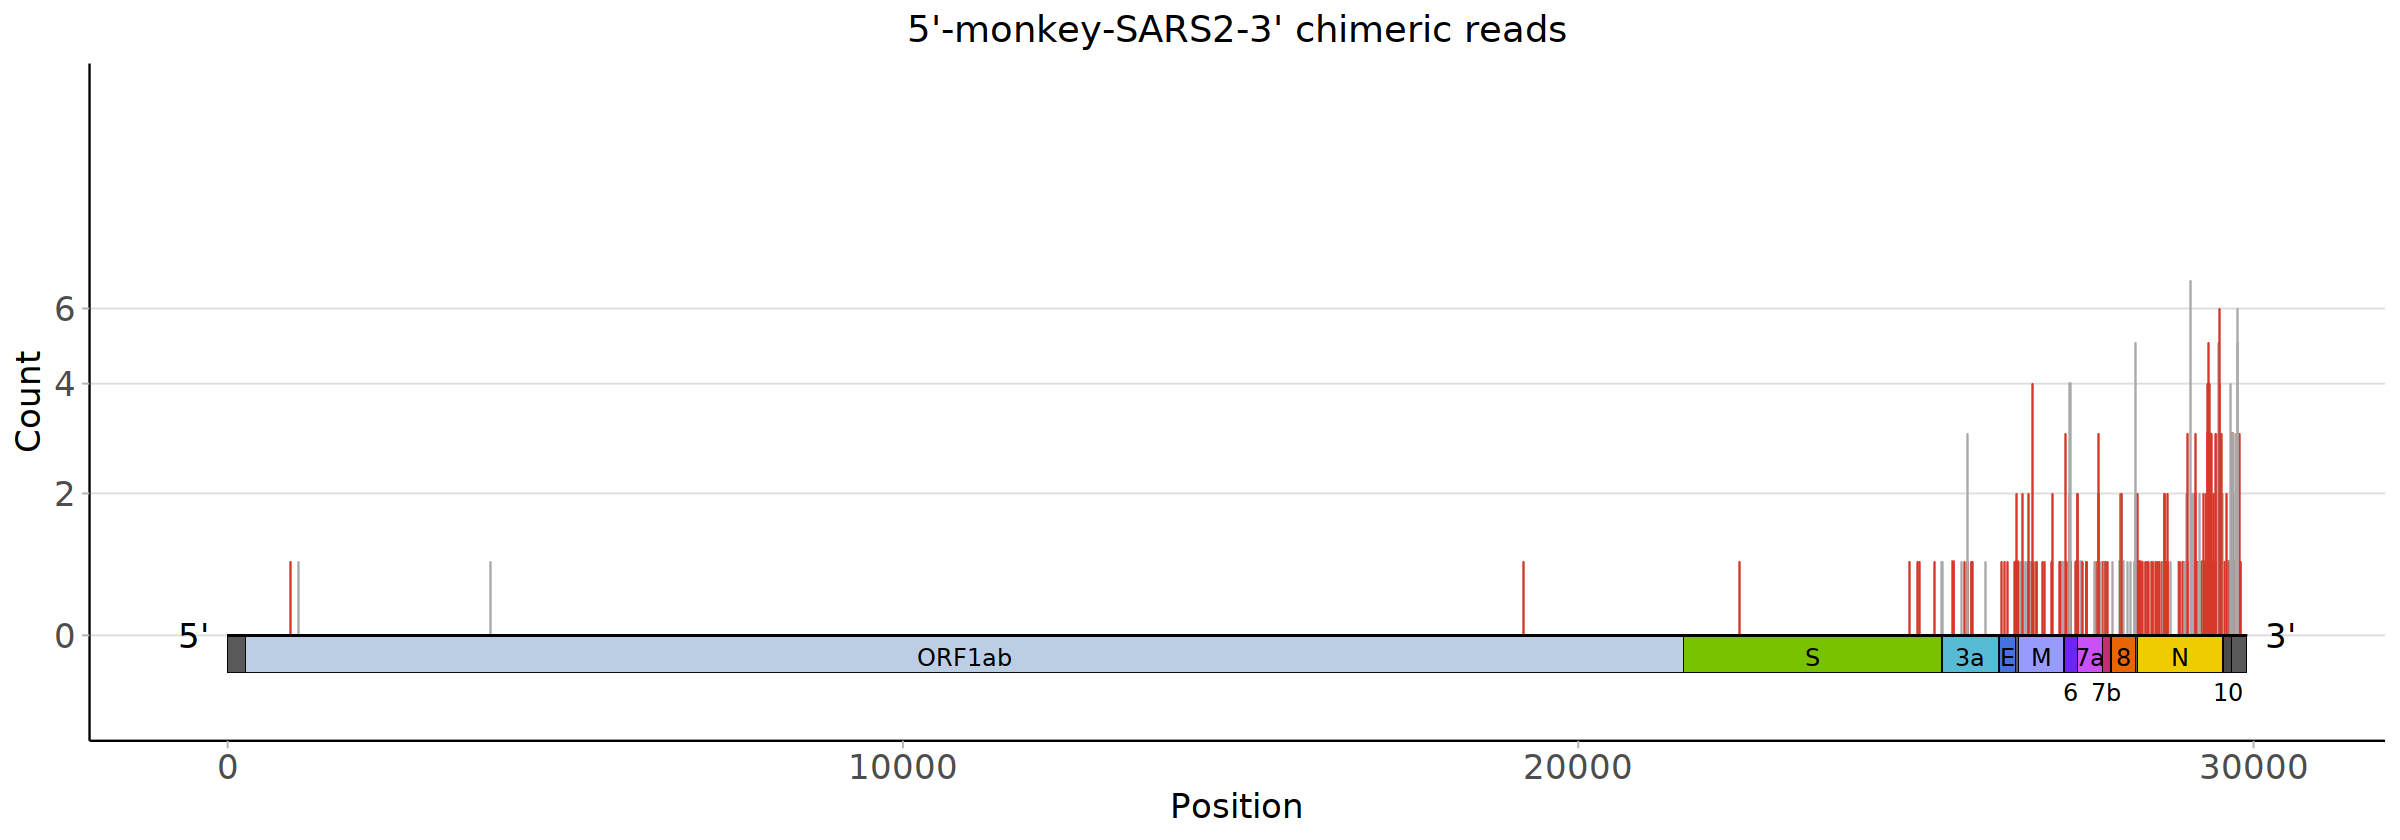

In [42]:
options(repr.plot.width=20, repr.plot.height=7)
p3

In [45]:
pdf("Figure_1_left_part.pdf", family="ArialMT", width=20, height=30)
# options(repr.plot.width=20, repr.plot.height=30)
p1 / p2 / p3 / p4
dev.off()

png 
  2